# Cats/Dogs Image Classification using Transfer Learning(ResNet) in PyTorch

In [1]:
import os
import torch
import torchvision
import zipfile
import torchvision.transforms as T
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader


image_size = 64
batch_size = 128

## Exploring the Data

We'll download the images in PNG format from [this page](http://files.fast.ai/data), using some helper functions from the `torchvision` and `zipfile` packages.

In [2]:
# Dowload the dataset
dataset_url = "http://files.fast.ai/data/dogscats.zip"
download_url(dataset_url, '.')

In [3]:
with zipfile.ZipFile('./dogscats.zip') as zip:
    zip.extractall(path='./data')

The dataset is extracted to the directory `data/dogscats`. It contains 5 folders `models`, `samples`, `test1`, `valid` and `train` containing the training set (23000 images) and validation set (10000 images) respectively. Each of them contains 2 folders, one for each class of images. Let's verify this using `os.listdir`.

In [4]:
data_dir = './data/dogscats'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['models', 'valid', 'test1', 'train', 'sample']
['cats', 'dogs']


Let's look inside those folders, one from the training set and another from the test set.

In [5]:
dogs_train = os.listdir(data_dir + "/train/dogs")
print('No. of training examples for dogs:', len(dogs_train))

cats_train = os.listdir(data_dir + "/train/cats")
print('No. of training examples for cats:', len(cats_train))

dogs_val = os.listdir(data_dir + "/valid/dogs")
print('No. of val examples for dogs:', len(dogs_val))

cats_val = os.listdir(data_dir + "/valid/cats")
print('No. of val examples for cats:', len(cats_val))


No. of training examples for dogs: 11500
No. of training examples for cats: 11500
No. of val examples for dogs: 1000
No. of val examples for cats: 1000


Let's load the train and validation datasets using the ImageFolder class from torchvision. We will also resize and crop the images to 64x64 px.

In [6]:
train_dataset = ImageFolder(data_dir+'/train', transform=ToTensor())
val_dataset = ImageFolder(data_dir+'/valid', transform=ToTensor())

In [7]:
train_dataset = ImageFolder(data_dir + '/train', transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor()]))

val_dataset = ImageFolder(data_dir + '/valid', transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor()]))

Let's look at a sample element from the training dataset. Each element is a tuple, containing a image tensor and a label. Since the data consists of 64x64 px color images with 3 channels (RGB), each image tensor has the shape (3, 64, 64).

In [8]:
img, label = val_dataset[2]
print(img.shape, label)
img

torch.Size([3, 64, 64]) 0


tensor([[[0.6392, 0.5765, 0.5020,  ..., 0.6941, 0.6784, 0.6745],
         [0.4824, 0.5098, 0.6392,  ..., 0.6667, 0.6118, 0.5922],
         [0.4510, 0.6078, 0.6824,  ..., 0.6431, 0.4392, 0.3765],
         ...,
         [0.3333, 0.3216, 0.3333,  ..., 0.6784, 0.7333, 0.6902],
         [0.3647, 0.3608, 0.3490,  ..., 0.7569, 0.6824, 0.6157],
         [0.3725, 0.3569, 0.3647,  ..., 0.6275, 0.5294, 0.5490]],

        [[0.5333, 0.4627, 0.4000,  ..., 0.6510, 0.6235, 0.6157],
         [0.2824, 0.3098, 0.4902,  ..., 0.6235, 0.5843, 0.5686],
         [0.2667, 0.4549, 0.6000,  ..., 0.6078, 0.4588, 0.3961],
         ...,
         [0.3098, 0.2980, 0.3137,  ..., 0.6353, 0.6471, 0.6118],
         [0.3333, 0.3294, 0.3216,  ..., 0.6980, 0.6353, 0.5765],
         [0.3412, 0.3255, 0.3412,  ..., 0.6314, 0.5804, 0.5686]],

        [[0.3804, 0.3176, 0.2863,  ..., 0.4745, 0.4431, 0.4196],
         [0.3333, 0.2784, 0.3490,  ..., 0.4353, 0.4157, 0.4000],
         [0.3412, 0.3451, 0.3961,  ..., 0.4314, 0.3725, 0.

The list of classes is stored in the .classes property of the dataset. The numeric label for each element corresponds to index of the element's label in the list of classes.

In [9]:
print(train_dataset.classes)

['cats', 'dogs']


We can view the image using matplotlib, but we need to change the tensor dimensions to (64,64,3). Let's create a helper function to display an image and its label.

In [10]:
import matplotlib.pyplot as plt

def show_example(img, label):
    print('Label: ', train_dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Let's look at a couple of images from the dataset. As you can tell by the axis, these are 64x64px images.

Label:  cats (0)


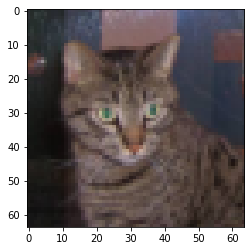

In [11]:
show_example(*train_dataset[1])

Label:  cats (0)


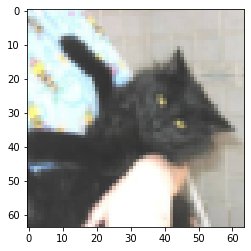

In [12]:
show_example(*train_dataset[1099])

## Training and Validation Datasets

We can now create data loaders for training and validation, to load the data in batches

In [13]:
train_dl = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_dataset, batch_size*2, num_workers=4, pin_memory=True)

We can look at batches of images from the dataset using the make_grid method from torchvision. Each time the following code is run, we get a different bach, since the sampler shuffles the indices before creating batches.

In [14]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=10).permute(1, 2, 0))
        break

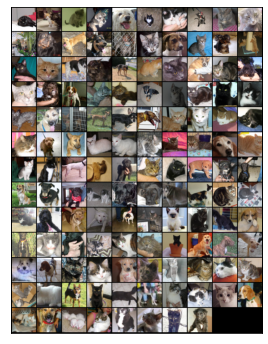

In [15]:
show_batch(train_dl)

## Defining the Model (Convolutional Neural Network)

Let's define the model by extending an ImageClassificationBase class which contains helper methods for training & validation.

In [16]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

[](http://)Using the ResNet models from torchvision.models

In [17]:
class DogsCatsCnnModelResNet18(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet18(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 2)
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

In [18]:
class DogsCatsCnnModelResNet34(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 2)
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

In [19]:
class DogsCatsCnnModelResNet50(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet50(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 2)
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

In [20]:
class DogsCatsCnnModelResNet101(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet101(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 2)
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

In [21]:
class DogsCatsCnnModelResNet152(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet152(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 2)
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

In [22]:
model_resnet_18 = DogsCatsCnnModelResNet18()
model_resnet_34 = DogsCatsCnnModelResNet34()
model_resnet_50 = DogsCatsCnnModelResNet50()
model_resnet_101 = DogsCatsCnnModelResNet101()
model_resnet_152 = DogsCatsCnnModelResNet152()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth


Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth


[](http://)Let's verify that the models produces the expected output on a batch of training data. The 2 outputs for each image can be interpreted as probabilities for the 2 target classes (after applying softmax), and the class with the highest probability is chosen as the label predicted by the model for the input image. 

In [23]:
# Considering for ResNet152
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model_resnet_152(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([128, 3, 64, 64])
out.shape: torch.Size([128, 2])
out[0]: tensor([0.2546, 0.3227], grad_fn=<SelectBackward>)


To seamlessly use a GPU, if one is available, we define a couple of helper functions (get_default_device & to_device) and a helper class DeviceDataLoader to move our model & data to the GPU as required. 

In [24]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Based on where you're running this notebook, your default device could be a CPU (torch.device('cpu')) or a GPU (torch.device('cuda'))

In [25]:
device = get_default_device()
device

device(type='cuda')

We can now wrap our training and validation data loaders using DeviceDataLoader for automatically transferring batches of data to the GPU (if available), and use to_device to move our models to the GPU (if available).

In [26]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model_resnet_18, device);
to_device(model_resnet_34, device);
to_device(model_resnet_50, device);
to_device(model_resnet_101, device);
to_device(model_resnet_152, device);

## Training the Model

We can define `fit` and `evaluate` functions to train our model.

In [27]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

Before we begin training, let's instantiate the models once again and see how they perform on the validation set with the initial set of parameters.

In [28]:
print(evaluate(model_resnet_18, val_dl))
print(evaluate(model_resnet_34, val_dl))
print(evaluate(model_resnet_50, val_dl))
print(evaluate(model_resnet_101, val_dl))
print(evaluate(model_resnet_152, val_dl))

{'val_loss': 0.699927568435669, 'val_acc': 0.5107046365737915}
{'val_loss': 0.7223952412605286, 'val_acc': 0.49534255266189575}
{'val_loss': 0.7065870761871338, 'val_acc': 0.4990609884262085}
{'val_loss': 0.6864721775054932, 'val_acc': 0.5555514097213745}
{'val_loss': 0.7428344488143921, 'val_acc': 0.3848407566547394}


We'll use the following hyperparmeters (learning rate, no. of epochs, batch_size etc.) to train our model.

In [29]:
num_epochs = 5
opt_func = torch.optim.Adam
lr = 0.001

In [30]:
history0 = fit(num_epochs, lr, model_resnet_18, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 0.4468, val_loss: 0.4780, val_acc: 0.8262
Epoch [1], train_loss: 0.4087, val_loss: 0.4651, val_acc: 0.8469
Epoch [2], train_loss: 0.3974, val_loss: 0.4293, val_acc: 0.8795
Epoch [3], train_loss: 0.3901, val_loss: 0.4434, val_acc: 0.8717
Epoch [4], train_loss: 0.3773, val_loss: 0.4236, val_acc: 0.8842


In [31]:
torch.save(model_resnet_18.state_dict(), 'dogscats-cnn-resnet18.pth')

In [32]:
history1 = fit(num_epochs, lr, model_resnet_34, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 0.4757, val_loss: 0.5162, val_acc: 0.7774
Epoch [1], train_loss: 0.4425, val_loss: 0.4509, val_acc: 0.8561
Epoch [2], train_loss: 0.4199, val_loss: 0.5628, val_acc: 0.7390
Epoch [3], train_loss: 0.4063, val_loss: 0.4588, val_acc: 0.8409
Epoch [4], train_loss: 0.4045, val_loss: 0.4281, val_acc: 0.8801


In [33]:
torch.save(model_resnet_34.state_dict(), 'dogscats-cnn-resnet34.pth')

In [34]:
history2 = fit(num_epochs, lr, model_resnet_50, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 0.4626, val_loss: 0.4283, val_acc: 0.8833
Epoch [1], train_loss: 0.4173, val_loss: 0.5683, val_acc: 0.7284
Epoch [2], train_loss: 0.4076, val_loss: 0.5176, val_acc: 0.7897
Epoch [3], train_loss: 0.3902, val_loss: 0.4482, val_acc: 0.8538
Epoch [4], train_loss: 0.3846, val_loss: 0.5235, val_acc: 0.7776


In [35]:
torch.save(model_resnet_50.state_dict(), 'dogscats-cnn-resnet50.pth')

In [36]:
history3 = fit(num_epochs, lr, model_resnet_101, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 0.4669, val_loss: 0.4452, val_acc: 0.8636
Epoch [1], train_loss: 0.4213, val_loss: 0.4552, val_acc: 0.8543
Epoch [2], train_loss: 0.4028, val_loss: 0.4420, val_acc: 0.8671
Epoch [3], train_loss: 0.3937, val_loss: 0.5190, val_acc: 0.7934
Epoch [4], train_loss: 0.3938, val_loss: 0.5830, val_acc: 0.7243


In [37]:
torch.save(model_resnet_101.state_dict(), 'dogscats-cnn-resnet101.pth')

In [38]:
history4 = fit(num_epochs, lr, model_resnet_152, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 0.4702, val_loss: 0.5305, val_acc: 0.7601
Epoch [1], train_loss: 0.4194, val_loss: 0.4933, val_acc: 0.8134
Epoch [2], train_loss: 0.3953, val_loss: 0.4447, val_acc: 0.8604
Epoch [3], train_loss: 0.3892, val_loss: 0.4470, val_acc: 0.8579
Epoch [4], train_loss: 0.3787, val_loss: 0.4302, val_acc: 0.8786


In [40]:
torch.save(model_resnet_152.state_dict(), 'dogscats-cnn-resnet152.pth')

We can also plot the valdation set accuracies to study how the models improves over time.

In [41]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

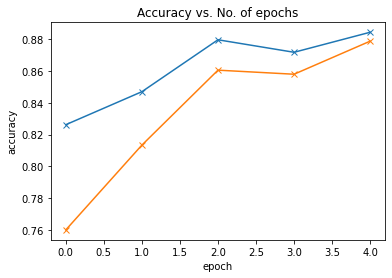

In [51]:
plot_accuracies(history0)
# plot_accuracies(history1)
# plot_accuracies(history2)
# plot_accuracies(history3)
# plot_accuracies(history4)

We can also plot the training and validation losses to study the trend.

In [43]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

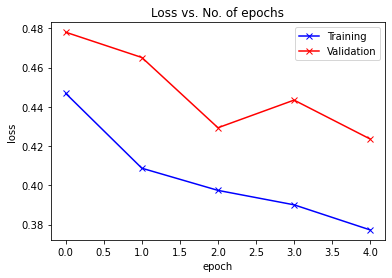

In [58]:
plot_losses(history0)
# plot_losses(history1)
# plot_losses(history2)
# plot_losses(history3)
# plot_losses(history4)

## Testing with individual images

While we have been tracking the overall accuracy of a model so far, it's also a good idea to look at model's results on some sample images. Let's test out our model with some images from the predefined test data of 12500 images. We begin by creating a test dataset using the `ImageFolder` class.
As ResNet 18 and ResNet 152 are having good accuracies we predict the outputs based on those models.


In [47]:
test_dataset = ImageFolder(data_dir , transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor()]))

In [59]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model_resnet_50(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_dataset.classes[preds[0].item()]

In [65]:
model1 = to_device(DogsCatsCnnModelResNet152(), device)

In [66]:
model1.load_state_dict(torch.load('dogscats-cnn-resnet152.pth'))

<All keys matched successfully>

Predicted: cats


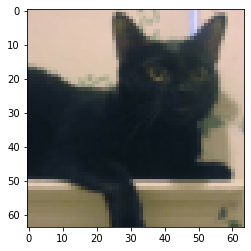

In [68]:
img, _ = test_dataset[0]
plt.imshow(img.permute(1, 2, 0))
print('Predicted:', predict_image(img, model1))

In [69]:
model2 = to_device(DogsCatsCnnModelResNet18(), device)

In [70]:
model2.load_state_dict(torch.load('dogscats-cnn-resnet18.pth'))

<All keys matched successfully>

Predicted: dogs


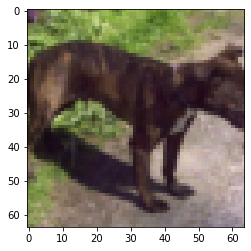

In [78]:
img, _ = test_dataset[1007]
plt.imshow(img.permute(1, 2, 0))
print('Predicted:', predict_image(img, model2))

Predicted: dogs


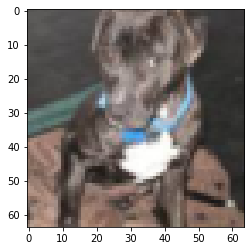

In [80]:
img, _ = test_dataset[1005]
plt.imshow(img.permute(1, 2, 0))
print('Predicted:', predict_image(img, model1))